In [1]:
# -*- coding: utf-8 -*-
# 基本モジュール
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm
#import pandas_profiling

import time
import datetime
import dateutil.parser #変数の時間型への変換で使用
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='meiryo.ttc')
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def grep_startswith(lst,word):
    tgt = []
    for string in lst:
        if string.startswith(word) == True:
            tgt.append(string)
    return tgt

def grep_endswith(lst,word):
    tgt = []
    for string in lst:
        if string.endswith(word) == True:
            tgt.append(string)
    return tgt

def grep_not_startswith(lst,word):
    tgt = []
    for string in lst:
        if string.startswith(word) == False:
            tgt.append(string)
    return tgt

def grep_not_endswith(lst,word):
    tgt = []
    for string in lst:
        if string.endswith(word) == False:
            tgt.append(string)
    return tgt

def grep_include(lst,word):
    tgt = []
    for string in lst:
        if string.find(word) != -1: #wordがstringに含まれている
            tgt.append(string)
    return tgt

def grep_not_include(lst,word):
    tgt = []
    for string in lst:
        if string.find(word) == -1: #wordがstringに含まれていない
            tgt.append(string)
    return tgt

def zfill2(x):
    return str(x).zfill(2)

def datetime_parser(x):
    return dateutil.parser.parse(x)


# カテゴリ変数の欠損は許容する版

In [4]:
app_train=pd.read_csv("application_train.csv")
print(len(app_train))

307511


In [5]:
app_train["TARGET"].value_counts()/len(app_train)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [6]:
app_test=pd.read_csv("application_test.csv")
print(len(app_test))

48744


In [7]:
# bureauデータの整形

bureau_data=pd.read_csv("bureau.csv")
# bureau_data.columns

bureau_data["CREDIT_CNT"]=1

cate_cols=['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

for tgt_col in cate_cols:
    tmp_DF=pd.get_dummies(bureau_data[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]
    bureau_data=pd.concat([bureau_data,tmp_DF],axis=1)
    del bureau_data[tgt_col]

del bureau_data["SK_ID_BUREAU"]

bureau_data["AMT_ANNUITY_BUREAU"]=bureau_data["AMT_ANNUITY"]
del bureau_data["AMT_ANNUITY"]

bureau_data2=bureau_data.fillna(0).groupby("SK_ID_CURR").sum().reset_index(drop=False)


In [8]:
# POS_CASHデータの整形

POS_data=pd.read_csv("POS_CASH_balance.csv")

#PREV_IDの数、SK_DPDの合計、SK_DPDの回数、分割数の平均
tmp_data1=POS_data.groupby(["SK_ID_CURR","SK_ID_PREV"]).mean()
tmp_data1["POS_ID_PREV_CNT"]=1
tmp_data1_2=tmp_data1.groupby(["SK_ID_CURR"]).sum()["POS_ID_PREV_CNT"]
tmp_data2=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD"]
POS_data["SK_DPD_CNT"]=POS_data["SK_DPD"].astype(bool).astype(int)
tmp_data3=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD_CNT"]
tmp_data4=tmp_data1.groupby(["SK_ID_CURR"]).sum()["CNT_INSTALMENT"]
POS_data2=pd.concat([tmp_data1_2,tmp_data2,tmp_data3,tmp_data4],axis=1)
POS_data2.columns=['POS_ID_PREV_CNT', 'POS_SK_DPD_SUM', 'POS_SK_DPD_CNT', 'POS_CNT_INSTALMENT_MEAN']
POS_data2=POS_data2.reset_index()

In [9]:
# CCBデータ加工 →現状、入れると精度が下がる
ccb_data=pd.read_csv("credit_card_balance.csv")

def is_minus(x):
    if x < 0:
        ret=1
    else:
        ret=0
    return ret

def ret_minus(x):
    if x < 0:
        ret=x
    else:
        ret=0
    return ret

tmp_data1=ccb_data.groupby(["SK_ID_CURR","SK_ID_PREV"]).mean()
ccb_data_mean=tmp_data1.reset_index().groupby("SK_ID_CURR").mean()
del ccb_data_mean["SK_ID_PREV"]
ccb_data_mean.columns=["CCB"+str(x)+"_MEAN" for x in ccb_data_mean.columns]
ccb_data_mean=ccb_data_mean.fillna(0).reset_index()

tmp_data1["CCB_num_of_loans"]=1
tmp_data1_2=tmp_data1.groupby(["SK_ID_CURR"]).sum()["CCB_num_of_loans"].reset_index()

ccb_data["CCB_ROW_CNT"]=1
ccb_data["CCB_SK_DPD_CNT"]=ccb_data["SK_DPD"].astype(float).astype(int)
ccb_data["CCB_SK_DPD_DEF_CNT"]=ccb_data["SK_DPD_DEF"].astype(float).astype(int)

tmp_data2=ccb_data.groupby(["SK_ID_CURR"]).sum()[["CCB_SK_DPD_DEF_CNT","CCB_SK_DPD_DEF_CNT","CCB_ROW_CNT"]].reset_index()
del tmp_data2["CCB_ROW_CNT"]
tmp_data3=ccb_data.groupby(["SK_ID_CURR"]).mean()[["SK_DPD","SK_DPD_DEF"]].reset_index()
tmp_data3.columns=["SK_ID_CURR","SK_DPD_MEAN","SK_DPD_DEF_MEAN"]

ccb_data["CCB_LESS_PAY_CNT"]=(ccb_data["AMT_PAYMENT_CURRENT"]-ccb_data["AMT_INST_MIN_REGULARITY"]).apply(is_minus)
ccb_data["CCB_LESS_PAY_VAL_MEAN"]=(ccb_data["AMT_PAYMENT_CURRENT"]-ccb_data["AMT_INST_MIN_REGULARITY"]).apply(ret_minus)
tmp_data4=ccb_data.groupby(["SK_ID_CURR"]).sum()[["CCB_LESS_PAY_CNT","CCB_ROW_CNT"]].reset_index()
tmp_data4_2=ccb_data.groupby(["SK_ID_CURR"]).mean()["CCB_LESS_PAY_VAL_MEAN"].reset_index()
tmp_data4["CCB_LESS_PAY_PCT"]=tmp_data4["CCB_LESS_PAY_CNT"]/tmp_data4["CCB_ROW_CNT"]
del tmp_data4["CCB_ROW_CNT"]

ccb_data2 = ccb_data_mean.merge(tmp_data1_2,on="SK_ID_CURR").merge(tmp_data2,on="SK_ID_CURR").merge(tmp_data3,on="SK_ID_CURR").merge(tmp_data4,on="SK_ID_CURR").merge(tmp_data4_2,on="SK_ID_CURR")

In [ ]:
# PREV_APPデータ加工
# prev_app_cont_mean
# prev_app_cate_sum

## ここから

In [35]:
app_data=pd.concat([app_train,app_test]).reset_index(drop=True)
print(len(app_data))
print(len(bureau_data2))
print(len(POS_data2))
print(len(ccb_data2))

356255
305811
337252
103558


In [36]:
#app_data['CODE_GENDER']=app_data['CODE_GENDER'].replace("XNA",np.nan)#.value_counts()
#app_data['ORGANIZATION_TYPE']=app_data['ORGANIZATION_TYPE'].replace("XNA",np.nan)

app_data2=app_data.replace("XNA",np.nan)#.replace("N",np.nan)

In [37]:
tgt_col='CODE_GENDER'
tmp_DF=pd.get_dummies(app_data2[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data2=pd.concat([app_data2,tmp_DF],axis=1)
del app_data2[tgt_col]

app_data2["HOUR_APPR_PROCESS_START"]=app_data2["HOUR_APPR_PROCESS_START"].replace(0,24).replace(1,25).replace(2,26)

for tgt_col in grep_startswith(app_data2.columns,"NAME_"):
    #print(tgt_col)
    tmp_DF=pd.get_dummies(app_data2[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    app_data2=pd.concat([app_data2,tmp_DF],axis=1)
    del app_data2[tgt_col]
    
tgt_col='WEEKDAY_APPR_PROCESS_START'
tmp_DF=pd.get_dummies(app_data2[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data2=pd.concat([app_data2,tmp_DF],axis=1)
del app_data2[tgt_col]

app_data2['FLAG_OWN_CAR']=app_data2['FLAG_OWN_CAR'].replace("Y",1).replace("N",0)
app_data2['FLAG_OWN_REALTY']=app_data2['FLAG_OWN_REALTY'].replace("Y",1).replace("N",0)

#app_data2.head()

In [38]:
app_data2["EMERGENCYSTATE_MODE"]=app_data2["EMERGENCYSTATE_MODE"].replace("Yes",1).replace("No",0)

In [39]:
for tgt_col in ["HOUSETYPE_MODE","FONDKAPREMONT_MODE",'OCCUPATION_TYPE','ORGANIZATION_TYPE','WALLSMATERIAL_MODE']:
    #print(tgt_col)
    tmp_DF=pd.get_dummies(app_data2[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    app_data2=pd.concat([app_data2,tmp_DF],axis=1)
    del app_data2[tgt_col]

In [40]:
len(app_data2)

356255

In [41]:
# 一定数以上のユーザが持っている項目
col_lst1=[]
for tmp_col in tqdm(app_data2.columns):
    if app_data2[tmp_col].value_counts().sum()/len(app_data2) > 0.9:
        col_lst1.append(tmp_col)
print(len(col_lst1))
print(len(app_data2[col_lst1].dropna()))
        
col_lst1_2=[]
for tmp_col in tqdm(app_train.columns):
    if app_train[tmp_col].value_counts().sum()/len(app_train) > 0.9:
        col_lst1_2.append(tmp_col)
print(len(col_lst1_2))

100%|██████████| 241/241 [00:01<00:00, 188.05it/s]


187


  3%|▎         | 4/122 [00:00<00:03, 32.11it/s]

354228


100%|██████████| 122/122 [00:01<00:00, 84.35it/s]

65


In [42]:
col_lst1=grep_not_include(col_lst1,"TARGET")
print(len(col_lst1))
np.setdiff1d(col_lst1_2,col_lst1)

187


array(['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE',
       'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'TARGET',
       'WEEKDAY_APPR_PROCESS_START'], dtype='<U27')

In [43]:
app_data3=app_data2[col_lst1].dropna().reset_index(drop=True)
print(len(app_data3))
#print(len(app_data2.dropna()))

print(len(col_lst1))

354228
187


In [44]:
flag_data=app_data[["SK_ID_CURR","TARGET"]]
app_data4=pd.merge(app_data3,flag_data,on="SK_ID_CURR",how="left")
#app_data2.columns

In [45]:
train_data=app_data4[app_data4["TARGET"]==app_data4["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=50,n_jobs=-1,max_depth=25)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

305545
NG
0.9484167634881933
0.9995975455627283


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6b61ce748>]],
      dtype=object)

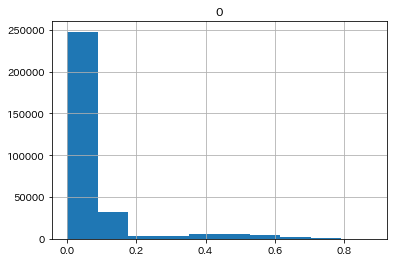

In [46]:
pd.DataFrame(ypred[:,1]).hist()

In [47]:
imp_data=pd.DataFrame([train_data_x.columns,model.feature_importances_]).T
imp_data.columns=["col","imp"]

imp_data=imp_data.sort_values("imp",ascending=False)
imp_data=imp_data.reset_index(drop=True)

imp_data["cumsum"]=imp_data.cumsum()["imp"]

imp_cols=np.array(imp_data[imp_data["cumsum"]<0.95]["col"])
print(len(imp_cols))

#model2 = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=10)
#model2.fit(train_data_x[imp_cols], train_data_y)

#ypred2=model2.predict(train_data_x[imp_cols])
#print(accuracy_score(train_data_y, ypred2))
#print(roc_auc_score(train_data_y, ypred2))

100


In [48]:
imp_cols_=["SK_ID_CURR","TARGET"]
imp_cols_.extend(imp_cols)

In [49]:
len(imp_cols_)

102

In [50]:
# dropnaしない状態で再度生成

In [54]:
app_data5=app_data2[imp_cols_].reset_index(drop=True)
print(len(app_data5))
#print(len(app_data2.dropna()))

356255


In [55]:
col_lst2=[]
for tmp_col in tqdm(imp_cols_):
    if app_data5[tmp_col].value_counts().sum()/len(app_data5) > 0.9:
        col_lst2.append(tmp_col)
print(len(col_lst2))
print(len(app_data5[col_lst2].dropna()))

100%|██████████| 102/102 [00:00<00:00, 194.99it/s]


101
354228


In [56]:
# app_data6　これが①データ
app_data6=app_data5[col_lst2].dropna().reset_index(drop=True)
print(len(app_data6))
#print(len(app_data2.dropna()))

print(len(col_lst2))

354228
101


In [57]:
# 結合
merged_data1=pd.merge(app_data6,bureau_data2,on="SK_ID_CURR",how="inner").merge(prev_app_cate_sum,on="SK_ID_CURR",how="inner")
merged_data1=pd.merge(merged_data1,POS_data2,on="SK_ID_CURR",how="inner").merge(prev_app_cate_sum,on="SK_ID_CURR",how="inner")

print(len(merged_data1))
print(len(merged_data1.columns))

merged_data2=pd.merge(app_data6,bureau_data2,on="SK_ID_CURR",how="inner").merge(prev_app_cate_sum,on="SK_ID_CURR",how="inner")
merged_data3=pd.merge(app_data6,POS_data2,on="SK_ID_CURR",how="inner").merge(prev_app_cate_sum,on="SK_ID_CURR",how="inner")

print(len(merged_data2))
print(len(merged_data2.columns))
print(len(merged_data3))
print(len(merged_data3.columns))

287247
407
289697
270
334186
238


288433
304162
335583


In [58]:
merged_data1=pd.merge(merged_data1,flag_data,on="SK_ID_CURR",how="left")
merged_data2=pd.merge(merged_data2,flag_data,on="SK_ID_CURR",how="left")
merged_data3=pd.merge(merged_data3,flag_data,on="SK_ID_CURR",how="left")

In [59]:
train_data=merged_data1[merged_data1["TARGET"]==merged_data1["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1,max_depth=25,min_samples_leaf=3)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

245887
NG
0.9287396242989666
0.9989044209624143


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6b64d08d0>]],
      dtype=object)

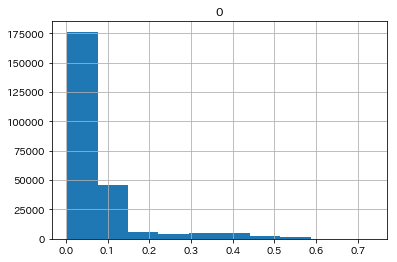

In [60]:
pd.DataFrame(ypred[:,1]).hist()

In [61]:
eval_data=merged_data1[merged_data1["TARGET"]!=merged_data1["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data1=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data1.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data1))

41360
41360


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6b64f2c18>]],
      dtype=object)

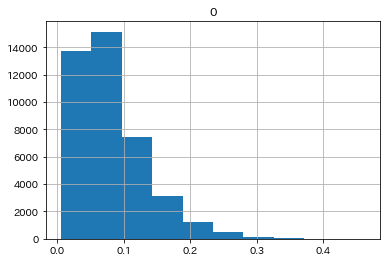

In [62]:
pd.DataFrame(ypred[:,1]).hist()

In [63]:
train_data=merged_data2[merged_data2["TARGET"]==merged_data2["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1,max_depth=25,min_samples_leaf=3)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

248148
NG
0.9287118977384464
0.9990205631992052


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6b64ad4a8>]],
      dtype=object)

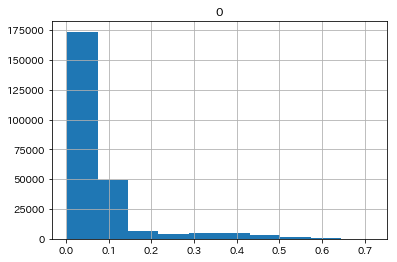

In [64]:
pd.DataFrame(ypred[:,1]).hist()

In [65]:
eval_data=merged_data2[merged_data2["TARGET"]!=merged_data2["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data2=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data2.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data2))

41549
41549


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6bfc16be0>]],
      dtype=object)

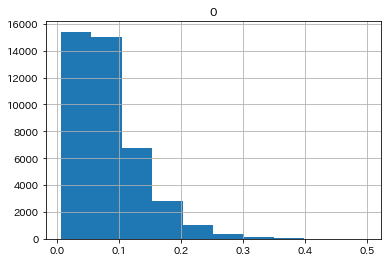

In [66]:
pd.DataFrame(ypred[:,1]).hist()

In [67]:
train_data=merged_data3[merged_data3["TARGET"]==merged_data3["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1,max_depth=25,min_samples_leaf=3)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

286649
NG
0.9238022808382377
0.9980381486124201


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6bfc21b70>]],
      dtype=object)

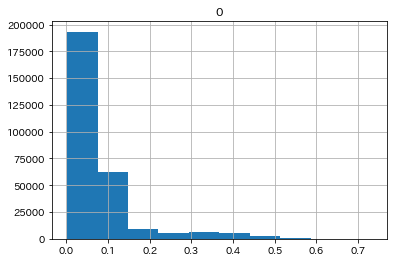

In [68]:
pd.DataFrame(ypred[:,1]).hist()

In [69]:
eval_data=merged_data3[merged_data3["TARGET"]!=merged_data3["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data3=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data3.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data3))

47537
47537


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6b148bd68>]],
      dtype=object)

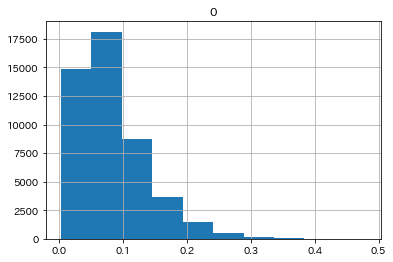

In [70]:
pd.DataFrame(ypred[:,1]).hist()

In [71]:
diff_2_1=np.setdiff1d(submit_data2["SK_ID_CURR"],submit_data1["SK_ID_CURR"])
diff_3_1=np.setdiff1d(submit_data3["SK_ID_CURR"],submit_data1["SK_ID_CURR"])

In [72]:
print(len(diff_2_1))
print(len(diff_3_1))

189
6177


In [73]:
submit_data2_2=submit_data2.set_index("SK_ID_CURR").ix[diff_2_1].reset_index()
submit_data3_2=submit_data3.set_index("SK_ID_CURR").ix[diff_3_1].reset_index()


In [74]:
submit_data=pd.concat([submit_data1,submit_data2_2,submit_data3_2])

In [95]:
len(submit_data)

48474

In [96]:
len(np.setdiff1d(app_test["SK_ID_CURR"],submit_data["SK_ID_CURR"]))

270

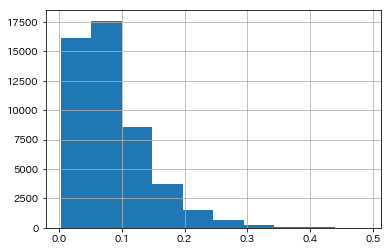

In [97]:
submit_data["TARGET"].hist()

In [108]:
# 未提出IDのデータを抽出
submit_data_tmp=submit_data.copy()
submit_data_tmp["submit"]=1
#submit_data_tmp=submit_data_tmp[["SK_ID_CURR","submit"]].copy()
app_data_tmp=pd.merge(app_data2,submit_data_tmp[["SK_ID_CURR","submit"]],on="SK_ID_CURR",how="outer")
app_data_nosubmit=app_data_tmp[(app_data_tmp["TARGET"]!=app_data_tmp["TARGET"])&(app_data_tmp["submit"]!=app_data_tmp["submit"])]
app_data_nosubmit=app_data_nosubmit.replace("XNA",np.nan)
len(app_data_nosubmit)

270

In [109]:
len(app_data[app_data["TARGET"]!=app_data["TARGET"]])-len(submit_data)

270

In [110]:
len(app_data_nosubmit.columns)

242

In [100]:
# 2周目

In [111]:
col_lst2=[]
for tmp_col in tqdm(app_data_nosubmit.columns):
#    if app_data_nosubmit[tmp_col].value_counts().sum()/len(app_data_nosubmit) > 0.95:
    if app_data_nosubmit[tmp_col].value_counts().sum()/len(app_data_nosubmit) > 0.9:
        col_lst2.append(tmp_col)
        
print(len(app_data_nosubmit[col_lst2].dropna()))

100%|██████████| 242/242 [00:00<00:00, 828.52it/s]


238


In [112]:
col_lst2=grep_not_include(col_lst2,"TARGET")
print(len(col_lst2))
np.setdiff1d(col_lst2,col_lst1)

183


array([], dtype='<U49')

In [113]:
app_data2_2=app_data2[col_lst2].dropna().reset_index(drop=True)
#flag_data=app_data[["SK_ID_CURR","TARGET"]]
app_data2_2=pd.merge(app_data2_2,flag_data,on="SK_ID_CURR",how="left")

print(len(app_data2_2.columns))
print(len(app_data2_2))

184
355274


In [116]:
train_data=app_data2_2[app_data2_2["TARGET"]==app_data2_2["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

306562


In [117]:
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1,max_depth=30,min_samples_leaf=3)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

0.9211774453454766
0.9983888686468464


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fe869fcc0>]],
      dtype=object)

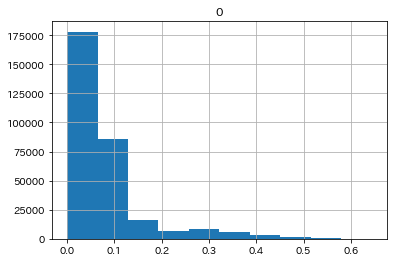

In [118]:
pd.DataFrame(ypred[:,1]).hist()

In [119]:
eval_data=app_data2_2[app_data2_2["TARGET"]!=app_data2_2["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)
#ypred2=model2.predict_proba(eval_data_x[imp_cols])

48712


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ffe50f588>]],
      dtype=object)

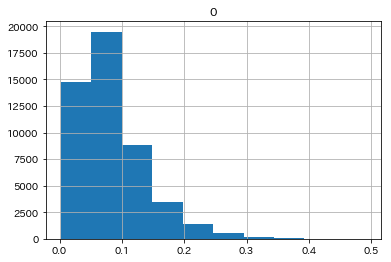

In [120]:
pd.DataFrame(ypred[:,1]).hist()

In [121]:
submit_data_tmp=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data_tmp.columns=["SK_ID_CURR","TARGET"]
#submit_data.to_csv("submit_data_0527_01.csv",index=False,header=True)
print(len(submit_data_tmp))

48712


In [122]:
submit_data4=pd.merge(app_data_nosubmit[["SK_ID_CURR"]],submit_data_tmp,on="SK_ID_CURR",how="inner")

In [123]:
print(len(app_data_nosubmit))
print(len(submit_data))
print(len(submit_data4))
print(len(submit_data)+len(submit_data4))
print(len(app_test))

print(len(app_test)-len(submit_data)-len(submit_data4))

270
48474
238
48712
48744
32


In [124]:
# 未提出IDのデータを抽出
submit_data_tmp=pd.concat([submit_data,submit_data4])
submit_data_tmp["submit"]=1
#submit_data_tmp=submit_data_tmp[["SK_ID_CURR","submit"]].copy()
app_data_tmp=pd.merge(app_data2,submit_data_tmp[["SK_ID_CURR","submit"]],on="SK_ID_CURR",how="outer")
app_data_nosubmit=app_data_tmp[(app_data_tmp["TARGET"]!=app_data_tmp["TARGET"])&(app_data_tmp["submit"]!=app_data_tmp["submit"])]
app_data_nosubmit=app_data_nosubmit.replace("XNA",np.nan)
print(len(app_data_nosubmit))

32


In [67]:
# 3周目

In [136]:
col_lst3=[]
for tmp_col in tqdm(app_data_nosubmit.columns):
    if app_data_nosubmit[tmp_col].value_counts().sum()/len(app_data_nosubmit) > 0.95:
        col_lst3.append(tmp_col)
        
print(len(app_data_nosubmit[col_lst3].dropna()))
print(len(col_lst3))

100%|██████████| 242/242 [00:00<00:00, 1377.97it/s]

32
185


In [137]:
np.setdiff1d(col_lst3,col_lst1)

array([], dtype='<U49')

In [138]:
app_data2_3=app_data2[col_lst3].dropna().reset_index(drop=True)
#flag_data=app_data[["SK_ID_CURR","TARGET"]]
app_data2_3=pd.merge(app_data2_3,flag_data,on="SK_ID_CURR",how="left")

print(len(app_data2_3.columns))
print(len(app_data2_3))

186
354926


In [139]:
train_data=app_data2_3[app_data2_3["TARGET"]==app_data2_3["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

306211


In [140]:
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1,max_depth=30,min_samples_leaf=3)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

0.9193105407709063
0.9987112257579045


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ffe262cf8>]],
      dtype=object)

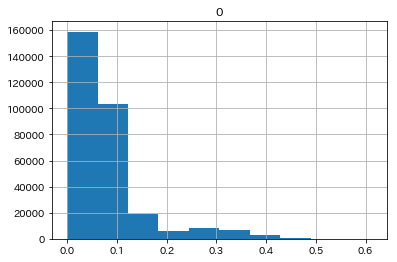

In [141]:
pd.DataFrame(ypred[:,1]).hist()

In [142]:
eval_data=app_data2_3[app_data2_3["TARGET"]!=app_data2_3["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)
#ypred2=model2.predict_proba(eval_data_x[imp_cols])

48715


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff6860a90>]],
      dtype=object)

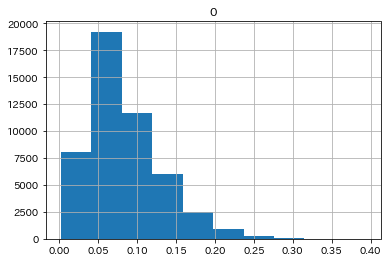

In [143]:
pd.DataFrame(ypred[:,1]).hist()

In [144]:
submit_data_tmp=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data_tmp.columns=["SK_ID_CURR","TARGET"]
#submit_data.to_csv("submit_data_0527_01.csv",index=False,header=True)
print(len(submit_data_tmp))

48715


In [145]:
submit_data5=pd.merge(app_data_nosubmit[["SK_ID_CURR"]],submit_data_tmp,on="SK_ID_CURR",how="inner")

In [146]:
print(len(app_data_nosubmit))
print(len(submit_data))
print(len(submit_data4))
print(len(submit_data5))
print(len(app_test)-(len(submit_data)+len(submit_data4)+len(submit_data5)))

32
48474
238
32
0


In [147]:
#app_data3_2=app_data3[app_data3["TARGET"]!=app_data3["TARGET"]]
#app_data3_2["TARGET"]=app_data3["TARGET"].mean()
submit_data6=pd.concat([submit_data,submit_data4,submit_data5]).sort_values("SK_ID_CURR")


In [148]:
print(len(submit_data))
print(len(submit_data4))
print(len(submit_data5))
print(len(submit_data6))

48474
238
32
48744


In [149]:
submit_data6=submit_data6.reset_index(drop=True)

In [150]:
submit_data6.to_csv("credit_submit_data_0606_02.csv",index=False,header=True)　 #ベスト
#tmp_data=pd.read_csv("credit_submit_data_0605_01.csv")

In [ ]:
# ④データを追加

In [268]:
# 全データ結合
merged_data1_2=pd.merge(app_data6,bureau_data2,on="SK_ID_CURR",how="inner")
merged_data1_2_3=pd.merge(merged_data1_2,POS_data2,on="SK_ID_CURR",how="inner")
merged_data1_2_3_4=pd.merge(merged_data1_2_3,ccb_data2,on="SK_ID_CURR",how="inner")

merged_data1_2_4=pd.merge(merged_data1_2,ccb_data2,on="SK_ID_CURR",how="inner")
merged_data1_4=pd.merge(app_data6,ccb_data2,on="SK_ID_CURR",how="inner")

print(len(merged_data1_2))
print(len(merged_data1_2.columns))

print(len(merged_data1_2_3))
print(len(merged_data1_2_3.columns))

print(len(merged_data1_2_3_4))
print(len(merged_data1_2_3_4.columns))

print(len(merged_data1_2_4))
print(len(merged_data1_2_4.columns))

print(len(merged_data1_4))
print(len(merged_data1_4.columns))


304162
88
288433
92
87339
100
89858
96
103478
60


In [269]:
merged_data1_2_3_4=pd.merge(merged_data1_2_3_4,flag_data,on="SK_ID_CURR",how="left")

In [276]:
train_data=merged_data1_2_3_4[merged_data1_2_3_4["TARGET"]==merged_data1_2_3_4["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1,max_depth=25,min_samples_leaf=3)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

72855
NG
0.930437169720678
0.9999011187030756


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36ec586a58>]],
      dtype=object)

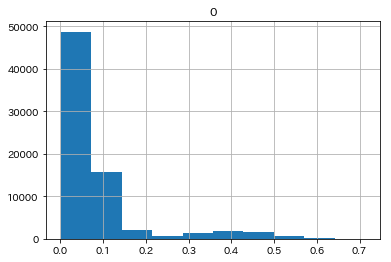

In [277]:
pd.DataFrame(ypred[:,1]).hist()

14484
14484


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36ec6c09e8>]],
      dtype=object)

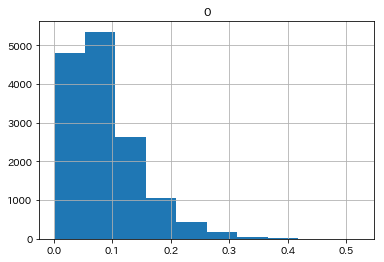

In [278]:
eval_data=merged_data1_2_3_4[merged_data1_2_3_4["TARGET"]!=merged_data1_2_3_4["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data1=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data1.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data1))

pd.DataFrame(ypred[:,1]).hist()

In [294]:
submit_data_tmp=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data_tmp.columns=["SK_ID_CURR","TARGET2"]

submit_data7=submit_data6.copy()
submit_data_tmp=submit_data_tmp.set_index("SK_ID_CURR")
submit_data7=submit_data6.set_index("SK_ID_CURR")

submit_data7.loc[submit_data_tmp.index,"TARGET"]=submit_data_tmp["TARGET2"]

In [293]:
submit_data7.reset_index().to_csv("credit_submit_data_0605_02.csv",index=False,header=True)

In [388]:
# 全データ結合
merged_data1_2=pd.merge(app_data6,bureau_data2,on="SK_ID_CURR",how="outer")
merged_data1_2_3=pd.merge(merged_data1_2,POS_data2,on="SK_ID_CURR",how="outer")
merged_data1_2_3_4=pd.merge(merged_data1_2_3,ccb_data2,on="SK_ID_CURR",how="outer")

#merged_data1_2_3_4=pd.merge(merged_data1_2_3_4,flag_data,on="SK_ID_CURR",how="outer")
#merged_data1_2_3_4=pd.merge(merged_data1_2_3_4,flag_data.dropna(subset=["TARGET"]),on="SK_ID_CURR",how="inner")

In [389]:
#tmp_data=merged_data1_2_3_4[["SK_ID_CURR",'AMT_ANNUITY',"AMT_ANNUITY_BUREAU","POS_ID_PREV_CNT","CCB_num_of_loans","TARGET"]].sort_values("SK_ID_CURR").set_index("SK_ID_CURR").fillna(0).astype(bool).astype(int)
tmp_data=merged_data1_2_3_4[["SK_ID_CURR",'AMT_ANNUITY',"AMT_ANNUITY_BUREAU","POS_ID_PREV_CNT","CCB_num_of_loans"]].sort_values("SK_ID_CURR").set_index("SK_ID_CURR").fillna(0).astype(bool).astype(int)
tmp_data.columns=["app_data","bureau","pos","ccb"]


In [390]:
tmp_data.to_csv("merged_0605.csv",index=False,header=True)

In [368]:
# 案：複数のデータセットでモデル生成して、もっとも確率の高いスコアを予測スコアとする

In [369]:
tmp_data["app_data"]=tmp_data["app_data"]*1
tmp_data["bureau"]=tmp_data["bureau"]*2
tmp_data["pos"]=tmp_data["pos"]*4
tmp_data["ccb"]=tmp_data["ccb"]*8

In [370]:
(tmp_data["app_data"]+tmp_data["bureau"]+tmp_data["pos"]+tmp_data["ccb"]).value_counts()

5     165955
13     63843
7      37852
15     20163
1      13126
9       2388
3       1778
4       1542
11       440
0        223
12        63
6         19
2         13
14         7
8          1
dtype: int64

In [371]:
tmp_data["CNT"]=1
tmp_data2=tmp_data.groupby(["app_data","bureau","pos","ccb"]).sum()

In [372]:
tmp_data2["pct"]=tmp_data2["TARGET"]/tmp_data2["CNT"]

In [373]:
tmp_data2.to_csv("merged_0605_aggr2.csv",index=True,header=True)

In [374]:
tmp_data2

TARGET     CNT       pct
app_data bureau pos ccb                          
0        0      0   0         2     223  0.008969
                    8         0       1  0.000000
                4   0       103    1542  0.066796
                    8         4      63  0.063492
         2      0   0         0      13  0.000000
                4   0         0      19  0.000000
                    8         0       7  0.000000
1        0      0   0       767   13126  0.058434
                    8       289    2388  0.121022
                4   0     12949  165955  0.078027
                    8      5358   63843  0.083925
         2      0   0       114    1778  0.064117
                    8        32     440  0.072727
                4   0      3356   37852  0.088661
                    8      1851   20163  0.091802

In [470]:
# ①③④だけのデータで予測して、対象者の結果を置き換える
tgt_index=tmp_data[(tmp_data["app_data"]==1)&(tmp_data["bureau"]==0)&(tmp_data["pos"]==1)&(tmp_data["ccb"]==1)].index

merged_data1_3_4_ex=app_data6.merge(POS_data2,on="SK_ID_CURR",how="inner").merge(ccb_data2,on="SK_ID_CURR",how="inner").set_index("SK_ID_CURR").ix[tgt_index]
merged_data1_3_4_ex=pd.merge(merged_data1_3_4_ex.reset_index(),flag_data,on="SK_ID_CURR",how="left")

In [471]:
print(len(tgt_index))
print(len(merged_data1_3_4_ex))

70011
70011


63843
NG
0.9677803361370863
0.9999992851732193


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36ebf858d0>]],
      dtype=object)

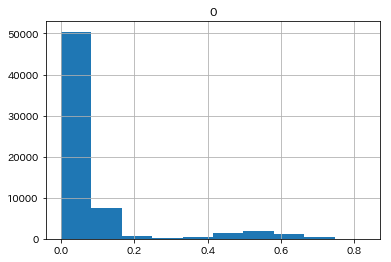

In [476]:
train_data=merged_data1_3_4_ex[merged_data1_3_4_ex["TARGET"]==merged_data1_3_4_ex["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1,max_depth=30,min_samples_leaf=2)
model.fit(train_data_x, train_data_y)

ypred=model.predict_proba(train_data_x)
print(accuracy_score(train_data_y,  np.argmax(ypred, axis=1)))
print(roc_auc_score(train_data_y, ypred[:,1]))

pd.DataFrame(ypred[:,1]).hist()

6168
6168


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36dc9a23c8>]],
      dtype=object)

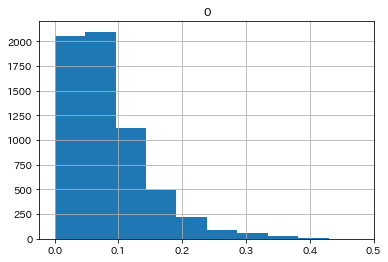

In [477]:
eval_data=merged_data1_3_4_ex[merged_data1_3_4_ex["TARGET"]!=merged_data1_3_4_ex["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data1=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data1.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data1))

pd.DataFrame(ypred[:,1]).hist()

In [478]:
submit_data_tmp=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data_tmp.columns=["SK_ID_CURR","TARGET2"]

submit_data8=submit_data6.copy()
submit_data_tmp=submit_data_tmp.set_index("SK_ID_CURR")
#submit_data8=submit_data6.set_index("SK_ID_CURR")

submit_data8.loc[submit_data_tmp.index,"TARGET"]=submit_data_tmp["TARGET2"]

print(len(submit_data6["TARGET"])-(submit_data6["TARGET"]==submit_data8["TARGET"]).astype(int).sum())

6168


In [479]:
submit_data8.to_csv("credit_submit_data_0606_01.csv",index=True,header=True)

In [86]:
submit_data.columns=["SK_ID_CURR","TARGET2"]
submit_data8=pd.read_csv("credit_submit_data_0606_02.csv").set_index("SK_ID_CURR")
submit_data_tmp=submit_data.copy()
submit_data_tmp=submit_data_tmp.set_index("SK_ID_CURR")
submit_data8.loc[submit_data_tmp.index,"TARGET"]=submit_data_tmp["TARGET2"]

In [87]:
submit_data8

,TARGET
SK_ID_CURR,
100001,0.032999
100005,0.122049
100013,0.032425
100028,0.055379
100038,0.120729
100042,0.087154
100057,0.030096
100065,0.114249
100066,0.076494


In [88]:
submit_data8.to_csv("credit_submit_data_0606_03.csv",index=True,header=True)

In [89]:
len(submit_data8)

48744

In [82]:
submit_data8.head()

,SK_ID_CURR,TARGET
0,100001,0.120729
1,100005,0.077152
2,100013,0.039225
3,100028,0.140609
4,100038,0.022820


In [24]:
prev_app=pd.read_csv("previous_application.csv")
prev_app=prev_app.replace("XNA",np.nan)
print(prev_app.shape)
print(len(prev_app["SK_ID_CURR"].value_counts()))

(1670214, 37)
338857


In [25]:
len(prev_app.sort_values(["SK_ID_CURR","SK_ID_PREV"]))
# 2種類のIDの組み合わせはユニークらしい

1670214

In [26]:
prev_app2=prev_app.copy()
#prev_app2["FLAG_LAST_APPL_PER_CONTRACT"]=prev_app2["FLAG_LAST_APPL_PER_CONTRACT"].replace("Y",1).replace("N",0)
for tgt_col in tqdm(["NAME_CONTRACT_TYPE","WEEKDAY_APPR_PROCESS_START","NAME_CASH_LOAN_PURPOSE","NAME_CONTRACT_STATUS",
                     "NAME_PAYMENT_TYPE","CODE_REJECT_REASON","NAME_TYPE_SUITE","NAME_CLIENT_TYPE","NAME_GOODS_CATEGORY",
                     "NAME_PORTFOLIO","NAME_PRODUCT_TYPE","FLAG_LAST_APPL_PER_CONTRACT","CHANNEL_TYPE","NAME_SELLER_INDUSTRY",
                     "NAME_YIELD_GROUP","PRODUCT_COMBINATION"]):
    #print(tgt_col)
    tmp_DF=pd.get_dummies(prev_app2[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    prev_app2=pd.concat([prev_app2,tmp_DF],axis=1)
    del prev_app2[tgt_col]

100%|██████████| 16/16 [00:37<00:00,  2.33s/it]


In [27]:
prev_app2_cate=pd.concat([prev_app2[prev_app2.columns[1:2]],prev_app2[prev_app2.columns[21:]]],axis=1)
prev_app2_cont=prev_app2[prev_app2.columns[:21]]
prev_app2_cont["HOUR_APPR_PROCESS_START"]=prev_app2_cont["HOUR_APPR_PROCESS_START"].replace(0,24).replace(1,25).replace(2,26)

In [28]:
grep_include(prev_app2_cont.columns,"FLAG")

['NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL']

In [29]:
print(len(prev_app["SK_ID_CURR"].value_counts()))
print(len(prev_app[prev_app["NAME_CONTRACT_STATUS"]!="Canceled"]["SK_ID_CURR"].value_counts()))

338857
338602


In [30]:
# 案：キャンセルになったレコードを削除する or しないで２パターン試す

In [31]:
prev_app2_cont=prev_app2_cont[prev_app2["NAME_CONTRACT_STATUS_Canceled"]!=1]
del prev_app2_cont["SK_ID_PREV"]
prev_app_cont_mean=prev_app2_cont.groupby("SK_ID_CURR").mean()

In [32]:
col_lst_prev_app=[]
for tmp_col in tqdm(prev_app_cont_mean.columns):
    if prev_app_cont_mean[tmp_col].value_counts().sum()/len(prev_app_cont_mean) > 0.95:
        col_lst_prev_app.append(tmp_col)

print(len(prev_app_cont_mean))
print(len(prev_app_cont_mean[col_lst_prev_app].dropna()))
print(len(col_lst_prev_app))

100%|██████████| 19/19 [00:00<00:00, 66.76it/s]


338602
336519
15


In [33]:
# ⑤データ
prev_app_cont_mean=prev_app_cont_mean[col_lst_prev_app].dropna()
#prev_app2_cont.sort_values("SK_ID_CURR")
prev_app_cont_mean.columns=["6_"+str(x)+"_mean" for x in prev_app_cont_mean.columns]
prev_app_cont_mean=prev_app_cont_mean.reset_index()

In [34]:
# ⑥データ
prev_app_cate_sum=prev_app2_cate.groupby("SK_ID_CURR").sum()
prev_app_cate_sum.columns=["6_"+str(x)+"_sum" for x in prev_app_cate_sum.columns]
prev_app_cate_sum=prev_app_cate_sum.reset_index()

In [232]:
prev_app.sort_values(["SK_ID_CURR","SK_ID_PREV"])[["SK_ID_CURR","SK_ID_PREV","NAME_CONTRACT_STATUS"]]

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS
201668,100001,1369693,Approved
892077,100002,1038818,Approved
575941,100003,1810518,Approved
1223745,100003,2396755,Approved
1021650,100003,2636178,Approved
935548,100004,1564014,Approved
1259112,100005,1857999,Canceled
1378978,100005,2495675,Approved
1131133,100006,1020698,Approved
1232752,100006,1243599,Canceled


In [492]:
col_lst_prev_app=[]
for tmp_col in tqdm(prev_app.columns):
    if prev_app[tmp_col].value_counts().sum()/len(prev_app) > 0.9:
        col_lst_prev_app.append(tmp_col)
        
print(len(prev_app[col_lst_prev_app].dropna()))
print(len(col_lst_prev_app))

100%|██████████| 37/37 [00:05<00:00,  6.71it/s]


1662689
16


In [ ]:
inst_pay=pd.read_csv("installments_payments.csv")
inst_pay=inst_pay.replace("XNA",np.nan)

In [445]:
inst_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [480]:
len(inst_pay["SK_ID_CURR"].value_counts())

339587

In [ ]:
# TODO:階層的なデータ構造を反映する

In [80]:
CCB_FULL = pd.read_csv('credit_card_balance.csv')

In [88]:
CCB = CCB_FULL[0:]
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
#gc.collect()
#print(CCB.dtypes, CCB.shape)
CCB1=CCB.copy()

In [87]:
CCB.groupby("SK_ID_CURR").mean()["NO_LOANS"].value_counts()

1.0    102818
2.0       732
3.0         7
4.0         1
Name: NO_LOANS, dtype: int64

In [89]:
# CNT_INSTALMENT_MATURE_CUM gives number of installments paid as of that month 
# The Max of this column shows the total number of installments made for that loan 

CCB = CCB_FULL[0:]

# No of Loans per customer 

CCB = CCB_FULL[0:]
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
#gc.collect()

#print(CCB.dtypes)


# No of Installments paid per Loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NO_INSTALMENTS'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NO_INSTALMENTS': 'TOTAL_INSTALMENTS'})
CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
#gc.collect()

# Average Number of installments paid per loan 

CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS']/CCB['NO_LOANS']).astype('uint32')
del CCB['TOTAL_INSTALMENTS']
del CCB['NO_LOANS']
#gc.collect()

#print(CCB.dtypes, CCB.shape)

CCB2=CCB.copy()

In [90]:
CCB2.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,INSTALLMENTS_PER_LOAN
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.0,1,0.0,1.0,35.0,Active,0,0,39
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0,69
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0,36
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0,13
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0,101


In [ ]:
CCB = CCB_FULL[0:]

CCB['AMT_CREDIT_LIMIT_ACTUAL1'] = CCB['AMT_CREDIT_LIMIT_ACTUAL']

def f(x1, x2):
    
    balance = x1.max()
    limit = x2.max()
    
    return (balance/limit)

# Calculate the ratio of Amount Balance to Credit Limit - CREDIT LOAD OF CUSTOMER 
# This is done for each Credit limit value per loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(lambda x: f(x.AMT_BALANCE, x.AMT_CREDIT_LIMIT_ACTUAL1)).reset_index().rename(index = str, columns = {0: 'CREDIT_LOAD1'})
del CCB['AMT_CREDIT_LIMIT_ACTUAL1']
gc.collect()

# We now calculate the mean Credit load of All Loan transactions of Customer 
grp1 = grp.groupby(by = ['SK_ID_CURR'])['CREDIT_LOAD1'].mean().reset_index().rename(index = str, columns = {'CREDIT_LOAD1': 'CREDIT_LOAD'})
print(grp1.dtypes)

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
gc.collect()

print(CCB.dtypes, CCB.shape)

In [ ]:
# Function to calculate number of times Days Past Due occurred 

CCB = CCB_FULL[0:]

def f(DPD):
    
    # DPD is a series of values of SK_DPD for each of the groupby combination 
    # We convert it to a list to get the number of SK_DPD values NOT EQUALS ZERO
    x = DPD.tolist()
    c = 0
    for i,j in enumerate(x):
        if j != 0:
            c += 1
    
    return c 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: f(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NO_DPD'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_DPD'].mean().reset_index().rename(index = str, columns = {'NO_DPD' : 'DPD_COUNT'})

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp1
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

In [71]:
CCB = CCB_FULL[0:]

grp = CCB.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'AVG_DPD'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

In [ ]:
CCB = CCB_FULL[0:]

def f(min_pay, total_pay):
    
    M = min_pay.tolist()
    T = total_pay.tolist()
    P = len(M)
    c = 0 
    # Find the count of transactions when Payment made is less than Minimum Payment 
    for i in range(len(M)):
        if T[i] < M[i]:
            c += 1  
    return (100*c)/P

grp = CCB.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MISSED_PAYMENTS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

In [ ]:
CCB = CCB_FULL[0:]

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'DRAWINGS_ATM'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'DRAWINGS_TOTAL'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['CASH_CARD_RATIO1'] = (CCB['DRAWINGS_ATM']/CCB['DRAWINGS_TOTAL'])*100
del CCB['DRAWINGS_ATM']
del CCB['DRAWINGS_TOTAL']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'CASH_CARD_RATIO1' : 'CASH_CARD_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['CASH_CARD_RATIO1']
gc.collect()

print(CCB.dtypes, CCB.shape)

# WE can leave NaN values as they are for LGBM 

In [ ]:
CCB = CCB_FULL[0:]

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'TOTAL_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'NO_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['DRAWINGS_RATIO1'] = (CCB['TOTAL_DRAWINGS']/CCB['NO_DRAWINGS'])*100
del CCB['TOTAL_DRAWINGS']
del CCB['NO_DRAWINGS']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'DRAWINGS_RATIO1' : 'DRAWINGS_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['DRAWINGS_RATIO1']

print(CCB.dtypes, CCB.shape)